In [1]:
import torch
import os
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

import sys
sys.path.append('../src')
from torch_utils import ResNet
from gradcam import *


In [2]:
#load model

def load_model(root_path, device):
    
    
    with open(os.path.join(root_path,'class_index.json'),'r') as f:
        class_index_dict = json.load(f)
        
    checkpoint_path = os.path.join(root_path,'checkpoint.pth')

    model = ResNet(34,len(class_index_dict))
    if not torch.cuda.is_available():
        model.load_state_dict(torch.load(checkpoint_path,map_location=torch.device('cpu')))
    else:
        model.load_state_dict(torch.load(checkpoint_path))

    model = model.to(device)
    model.eval()

    return model, class_index_dict


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

root_path = '../model_zoo/3000_random'
model, class_index_dict = load_model(root_path, device)

In [10]:
#load image

data_path = '/home/jcejudo/training_data_3000'
category = 'photograph'

filename_list = os.listdir(os.path.join(data_path,category))
idx = np.random.randint(len(filename_list))
image = Image.open(os.path.join(data_path,category,filename_list[idx]))

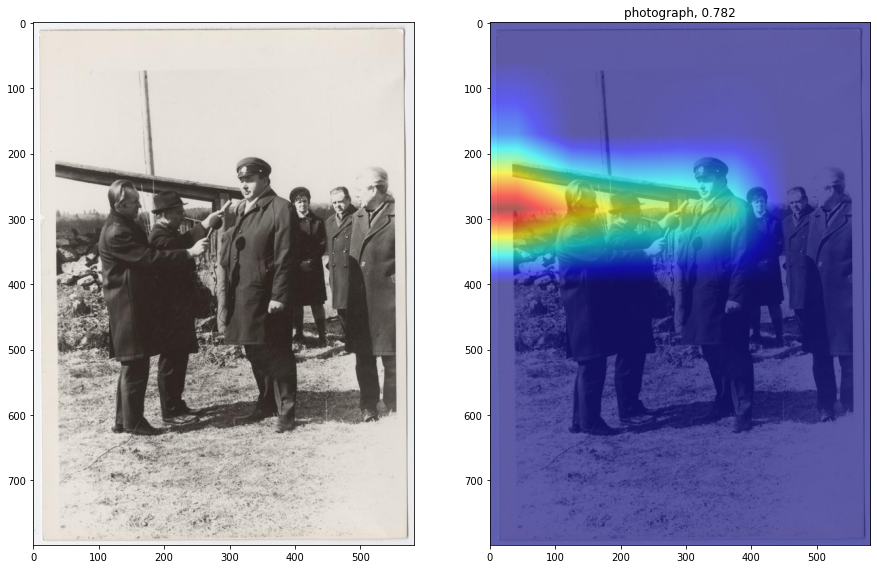

In [12]:
def predict_grad_cam(**kwargs):
    
    model = kwargs.get('model')
    image = kwargs.get('image')
    heatmap_layer = kwargs.get('heatmap_layer')
    transform = kwargs.get('transform')
    device = kwargs.get('device')
    thres = kwargs.get('thres',0.3)
    max_pred = kwargs.get('max_pred',5)
    
    #necessary for gradcam
    info = InfoHolder(heatmap_layer)
    heatmap_layer.register_forward_hook(info.hook)

    input_tensor = transform(image).unsqueeze(0).to(device)
    output = model(input_tensor)
    
    conf_tensor,indices_tensor = torch.sort(output.data,descending=True)
    conf_arr = conf_tensor[0].cpu().numpy()
    indices_arr = indices_tensor[0].cpu().numpy()

    sorted_conf_score = [conf for conf in conf_arr if conf > thres]
    
    n_pred = min(max_pred,len(sorted_conf_score))
    sorted_labels = [index for index in indices_arr][:n_pred]
    sorted_categories = [class_index_dict[str(label)] for label in sorted_labels]

    category_list = []
    conf_list = []
    XAI_list = []

    for label,cat,conf in zip(sorted_labels, sorted_categories, sorted_conf_score):

        output[0][label].backward(retain_graph=True)
        weights = torch.mean(info.gradient, [0, 2, 3])
        activation = info.activation.squeeze(0)
        weighted_activation = torch.zeros(activation.shape)
        for idx, (weight, activation) in enumerate(zip(weights, activation)):
            weighted_activation[idx] = weight * activation

        heatmap = generate_heatmap(weighted_activation)
        XAI = superimpose(np.asarray(image),heatmap)

        category_list.append(cat)
        conf_list.append(conf)
        XAI_list.append(XAI)

    return category_list, conf_list, XAI_list

def plot_grad_cam(**kwargs):
    
    image = kwargs.get('image')
    category_list = kwargs.get('category_list')
    confidence_list = kwargs.get('confidence_list')
    XAI_list = kwargs.get('XAI_list')
    ground_truth = kwargs.get('ground_truth')
    saving_path = kwargs.get('saving_path')
    
    fig,ax = plt.subplots(1,len(category_list)+1,figsize = (15,15))
    ax[0].imshow(image)
    if ground_truth:
        ax[0].set_title(ground_truth)
        
    for i, (cat, conf, XAI) in enumerate(zip(category_list, confidence_list, XAI_list)):
        ax[i+1].imshow(XAI)
        ax[i+1].set_title(f'{cat}, {conf:.3f}')
        
    if saving_path:
        plt.savefig(saving_path)
    
    
transform = transforms.Compose([
transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

thres = 0.3
max_pred = 5
heatmap_layer = model.net.layer4[1].conv2

category_list, confidence_list, XAI_list = predict_grad_cam(
    model = model, 
    image = image,
    heatmap_layer = heatmap_layer, 
    transform = transform, 
    device = device, 
    thres = thres, 
    max_pred = max_pred)

plot_grad_cam(
    image = image,
    category_list = category_list, 
    confidence_list = confidence_list,
    XAI_list = XAI_list,
)
    

In [54]:
values

tensor([[9.9874e-01, 4.2064e-04, 2.2238e-04, 1.6301e-04, 1.4811e-04, 9.3162e-05,
         4.5640e-05, 2.8314e-05, 2.7654e-05, 2.1024e-05, 1.4539e-05, 1.4382e-05,
         1.0452e-05, 9.7453e-06, 8.9313e-06, 8.8682e-06, 8.5939e-06, 8.3563e-06,
         2.6827e-06, 2.2985e-07]], device='cuda:0')

building 0.99874336
